# Sistema de Recomendación
---
Se crea un sistema de recomendación de películas. Para ello nos valemos de dos datasets, el primero con un amplio catálogo de películas y otro con valoraciones de usuarios a cada película. Para ello se emplea el método de filtrado colaborativo.

### Importanción de librerias y datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [2]:
df_movies = pd.read_csv('data/movies.csv', dtype={'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv('data/ratings.csv', dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
print(df_movies.shape)
print(df_ratings.shape)

(9742, 3)
(100836, 4)


In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Modificación y extracción de características

#### Dataset movies

Se crea un dummie por cada género de película para optimizar después el sistema de recomendación dentro del dataset de películas

In [5]:
df_movies2= pd.concat([df_movies, df_movies.genres.str.get_dummies(sep='|')], axis=1)
df_movies2.head(10)

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),Action|Crime|Thriller,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6,7,Sabrina (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7,8,Tom and Huck (1995),Adventure|Children,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),Action,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),Action|Adventure|Thriller,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
movie_categories= df_movies2.columns[3:]
df_movies2.loc[9]

movieId                                      10
title                          GoldenEye (1995)
genres                Action|Adventure|Thriller
(no genres listed)                            0
Action                                        1
Adventure                                     1
Animation                                     0
Children                                      0
Comedy                                        0
Crime                                         0
Documentary                                   0
Drama                                         0
Fantasy                                       0
Film-Noir                                     0
Horror                                        0
IMAX                                          0
Musical                                       0
Mystery                                       0
Romance                                       0
Sci-Fi                                        0
Thriller                                

#### Dataset ratings

Ahora vamos a eliminar el timestamp e incorporar al dataset de rating el título de la película

In [7]:
del df_ratings['timestamp']
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [8]:
df_ratings2=pd.merge(df_ratings, df_movies2, on= 'movieId')[['userId', 'title', 'movieId', 'rating']]
df_ratings2.head()

,userId,title,movieId,rating
0,1,Toy Story (1995),1,4.0
1,5,Toy Story (1995),1,4.0
2,7,Toy Story (1995),1,4.5
3,15,Toy Story (1995),1,2.5
4,17,Toy Story (1995),1,4.5


In [9]:
df_ratings2.shape

(100836, 4)

Ahora reconvertimos nuestra matríz a una que identifique las películas valoradas por cada usuario

In [10]:
ratings_matrix=df_ratings2.pivot_table(values='rating', index='userId', columns='title')
ratings_matrix.fillna(0, inplace=True)
ratings_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
movie_index=ratings_matrix.columns

### Analisis de correlación

In [12]:
corr_matrix=np.corrcoef(ratings_matrix.T)
corr_matrix.shape

(9719, 9719)

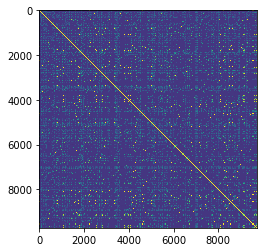

In [13]:
plt.imshow(corr_matrix)
plt.show()

# Recomendador de películas

Este recomendador encontrará películas similares a una película elegida 

In [14]:
#Introducimos la película de la cual queremos encontrar películas similares
fav_movie_title= 'GoldenEye (1995)'

In [15]:
fav_movie_index= list(movie_index).index(fav_movie_title)
P=corr_matrix[fav_movie_index]

In [16]:
list(movie_index[(P>0.4) & (P<1.0)])

['Batman (1989)',
 'Batman Forever (1995)',
 'Clear and Present Danger (1994)',
 'Cliffhanger (1993)',
 'Die Hard: With a Vengeance (1995)',
 'Mission: Impossible (1996)',
 'Speed (1994)',
 'Stargate (1994)',
 'True Lies (1994)']

# Recomendador de películas en función del historial

In [17]:
def get_movie_similarity(title):
    movie_idx= list(movie_index).index(title)
    return corr_matrix[movie_idx]
def get_movie_recommendations(user_movies):
    movie_similarities=np.zeros(corr_matrix.shape[0])
    for movieId in user_movies:
        movie_similarities=movie_similarities + get_movie_similarity(movieId)
    similarities_df=pd.DataFrame({
        'title': movie_index,
        'sum_similarity': movie_similarities
    })
    similarities_df=similarities_df[~(similarities_df.title.isin(user_movies))]
    similarities_df=similarities_df.sort_values(by=['sum_similarity'], ascending=False)
    return similarities_df

Creamos un usuario de prueba y aplicamos para ver que películas ha visto

In [18]:
sample_user= 10
df_ratings2[df_ratings2.userId==sample_user].sort_values(by=['rating'], ascending=False)

,userId,title,movieId,rating
43431,10,The Intern (2015),140110,5.0
39281,10,Batman Begins (2005),33794,5.0
42525,10,"Education, An (2009)",71579,5.0
42757,10,Despicable Me (2010),79091,5.0
42828,10,"King's Speech, The (2010)",81845,5.0
...,...,...,...,...
43316,10,"Grand Budapest Hotel, The (2014)",109374,0.5
23046,10,"Sixth Sense, The (1999)",2762,0.5
17903,10,Interstellar (2014),109487,0.5
14325,10,Fight Club (1999),2959,0.5


Ahora podemos generar nuevas recomendaciones para este usuario en función de las películas que ya ha visto

In [19]:
sample_user_movies=df_ratings2[df_ratings2.userId==sample_user].title.tolist()
recomendations= get_movie_recommendations(sample_user_movies)
print(recomendations.title.head(20))

9325                              Wedding Crashers (2005)
3738                                 Hangover, The (2009)
3790           Harry Potter and the Goblet of Fire (2005)
2366                        Devil Wears Prada, The (2006)
6646    Pirates of the Caribbean: The Curse of the Bla...
1431                                Bruce Almighty (2003)
6236                                Ocean's Eleven (2001)
3787       Harry Potter and the Chamber of Secrets (2002)
4826                                    Knocked Up (2007)
7428                                School of Rock (2003)
6643    Pirates of the Caribbean: Dead Man's Chest (2006)
3794    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6096                           Night at the Museum (2006)
6642      Pirates of the Caribbean: At World's End (2007)
2110                            Da Vinci Code, The (2006)
9367                               What Women Want (2000)
7442                   Scott Pilgrim vs. the World (2010)
8000    Star W

---
Vamos a presentar dichas películas recomendadas, junto con su puntuación promedio para que el usuario decida cual ve primero, atendiendo a las puntuaciones de los demas usuarios

In [20]:
ratings_matrix2=df_ratings2.pivot_table(values='rating', index='userId', columns='title')
ratings_matrix2.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
movies_mean= ratings_matrix2.mean()
movies_count=ratings_matrix2.count()
movies_rated=pd.concat([movies_mean, movies_count], axis=1).rename(columns={0:"mean rating", 1:"count"})
movies_rated=movies_rated.merge(df_movies, on= 'title')
movies_rated=movies_rated.drop(columns=['movieId'])
movies_rated.head(15)                                                                   

,title,mean rating,count,genres
0,'71 (2014),4.000000,1,Action|Drama|Thriller|War
1,'Hellboy': The Seeds of Creation (2004),4.000000,1,Action|Adventure|Comedy|Documentary|Fantasy
2,'Round Midnight (1986),3.500000,2,Drama|Musical
3,'Salem's Lot (2004),5.000000,1,Drama|Horror|Mystery|Thriller
4,'Til There Was You (1997),4.000000,2,Drama|Romance
5,'Tis the Season for Love (2015),1.500000,1,Romance
6,"'burbs, The (1989)",3.176471,17,Comedy
7,'night Mother (1986),3.000000,1,Drama
8,(500) Days of Summer (2009),3.666667,42,Comedy|Drama|Romance
9,*batteries not included (1987),3.285714,7,Children|Comedy|Fantasy|Sci-Fi


Tiene sentido que en el rating de una película, se tenga en cuenta el número de votos. Por ello, se crea esta variable score que va a tener en cuenta tanto el rating como el número de votos que ha recibido la película, usando la fórmula de Laplace.

In [22]:
movies_rated['score']= movies_rated.apply(lambda x: (x['mean rating']*x['count']+2.5)/(x['count']+2), axis=1)
movies_rated

,title,mean rating,count,genres,score
0,'71 (2014),4.000000,1,Action|Drama|Thriller|War,2.166667
1,'Hellboy': The Seeds of Creation (2004),4.000000,1,Action|Adventure|Comedy|Documentary|Fantasy,2.166667
2,'Round Midnight (1986),3.500000,2,Drama|Musical,2.375000
3,'Salem's Lot (2004),5.000000,1,Drama|Horror|Mystery|Thriller,2.500000
4,'Til There Was You (1997),4.000000,2,Drama|Romance,2.625000
...,...,...,...,...,...
9719,eXistenZ (1999),3.863636,22,Action|Sci-Fi|Thriller,3.645833
9720,xXx (2002),2.770833,24,Action|Crime|Thriller,2.653846
9721,xXx: State of the Union (2005),2.000000,5,Action|Crime|Thriller,1.785714
9722,¡Three Amigos! (1986),3.134615,26,Comedy|Western,3.000000


Así pues, las 10 películas recomendadas para este usuario en concreto, en función de sus gustos y ordenadas por score, son:

In [23]:
recomendations_rated=pd.merge(recomendations, movies_rated, on='title')[['title', 'score', 'genres']]
recomendations_rated.sort_values(by=["score"], ascending=False).head(10)

,title,score,genres
2842,"Shawshank Redemption, The (1994)",4.409091,Crime|Drama
1197,"Godfather, The (1972)",4.257732,Crime|Drama
1110,"Godfather: Part II, The (1974)",4.213740,Crime|Drama
2444,"Usual Suspects, The (1995)",4.208738,Crime|Mystery|Thriller
1190,Star Wars: Episode IV - A New Hope (1977),4.207510,Action|Adventure|Sci-Fi
1914,Dr. Strangelove or: How I Learned to Stop Worr...,4.207071,Comedy|War
1207,Goodfellas (1990),4.203125,Crime|Drama
3361,Schindler's List (1993),4.198198,Drama|War
189,"Departed, The (2006)",4.197248,Crime|Drama|Thriller
2390,Rear Window (1954),4.191860,Mystery|Thriller
